# Import

In [1]:
# !pip install rdkit
# !pip install albumentations

In [2]:
import random
import os

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [3]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
class CFG:
    SEED = 0
    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 256
    LEARNING_RATE = 0.003

<br></br>

# Data Load

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [8]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [9]:
# train_df.describe()

In [10]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [11]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [12]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [13]:
# train_df.nunique()

In [14]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Pre-Processing

<br>

## Set target range to [0,100]

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [15]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

## Make molecule features

In [16]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    #radius, nBits = 6, 4096
    radius, nBits = 12, (2**10)*3
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [17]:
# (1) SMILES를 통해 Molecule(분자구조) 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [18]:
from sklearn.feature_selection import VarianceThreshold

In [19]:
# (2) Morgan Fingerprint column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [20]:
# (3) Morgan Fingerprint 중, variance가 0.05보다 작은 컬럼들을 지우기
feature_select = VarianceThreshold(threshold=0.05)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))
print(tr_fps_selected.shape[1])

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]

train_df = pd.concat([train_df,pd.DataFrame(tr_fps_selected,columns=fps_names)],axis=1)
test_df  = pd.concat([test_df ,pd.DataFrame(te_fps_selected,columns=fps_names)],axis=1)

293


In [21]:
# 사용할 column만 추출
features = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors',
            'Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
fps_feature = 'FPs'
smiles_feature = 'SMILES'
targets  = ['MLM','HLM']

train_df = train_df[features+fps_names+[fps_feature,smiles_feature]+targets]
test_df  = test_df[features+fps_names+[fps_feature,smiles_feature]]

In [22]:
train_df.shape

(3498, 304)

In [23]:
train_df.head()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,...,fps288,fps289,fps290,fps291,fps292,fps293,FPs,SMILES,MLM,HLM
0,3.259,400.495,5,2,8,3.259,117.37,0,0,4,...,0,0,2,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680
1,2.169,301.407,2,1,2,2.172,73.47,0,0,3,...,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590
2,1.593,297.358,5,0,3,1.585,62.45,0,0,1,...,0,0,0,2,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892
3,4.771,494.652,6,0,5,3.475,92.60,0,0,3,...,2,0,0,0,0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000
4,2.335,268.310,3,0,1,2.337,42.43,0,0,2,...,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990


<br>

## Imputaion

In [24]:
from sklearn.impute import SimpleImputer

In [25]:
def null_check(data):
    d = data.copy()
    null_info = d.isnull().sum()
    null_info = null_info[null_info!=0]
    display(null_info)

In [26]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


AlogP    2
dtype: int64

> test


AlogP    1
dtype: int64

In [27]:
null_features = ['AlogP']

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df[null_features] = imputer.fit_transform(train_df[null_features])
test_df [null_features] = imputer.transform(test_df[null_features])

In [28]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


Series([], dtype: int64)

> test


Series([], dtype: int64)

<br></br>

# Kfold

In [29]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [30]:
from rdkit import Chem
from rdkit.Chem import Draw

class CustomDataset(Dataset):
    def __init__(self, data, targets, smiles, fps, fps_maximum, transforms=[None,None], is_test=False):
        self.data = data.copy()
        self.targets = targets
        self.smiles = smiles
        self.fps = fps
        self.smiles_transforms, self.fps_transforms = transforms
        self.is_test = is_test
        
        self.smiles_features = []
        for s in tqdm(data[smiles].values,desc='Setup smiles... '):
            m = Chem.MolFromSmiles(s)
            img = Draw.MolToImage(m)#, size=(224,224))
            img = np.array(img)
            if self.smiles_transforms is not None:
                img = self.smiles_transforms(image=img)['image']
            self.smiles_features.append(img)
        self.smiles_features = torch.stack(self.smiles_features)
        
        fps_values = (np.stack(data[fps])/fps_maximum)*255 # max -> 255
        self.fps_features = []
        for f in fps_values:
            img = f.reshape(32,32,3)
            if self.fps_transforms is not None:
                img = self.fps_transforms(image=img)['image']
            self.fps_features.append(img)
            
        if not self.is_test:
            self.target_features = self.data[self.targets].values
            self.num_features = self.data.drop(columns=targets+[fps,smiles],axis=1).values
        else:
            self.num_features = self.data.drop(columns=[fps,smiles],axis=1).values

    def __getitem__(self, index):
        if self.is_test:
            return (
                torch.Tensor(self.num_features[index]),
                torch.Tensor(self.smiles_features[index]),
                torch.Tensor(self.fps_features[index]),
            )
        else:
            return (
                torch.Tensor(self.num_features[index]),
                torch.Tensor(self.smiles_features[index]),
                torch.Tensor(self.fps_features[index]),
                torch.Tensor(self.target_features[index]),
            )
        
    def __len__(self):
        return len(self.data)

In [31]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

In [32]:
import torchvision.models as models

In [33]:
class MultiTaskModel(nn.Module):
    def __init__(self, feature_input_size, output_size, hidden_size, dropout_rate):
        super(MultiTaskModel, self).__init__()
        self.image_output_size = 500
        self.feature_output_size = 1000
        self.dropout_rate = dropout_rate
        
        # # efficientnet
        # self.backbone = models.efficientnet_b0(pretrained=True)
        # self.backbone.classifier = nn.Sequential(
        #     nn.Dropout(p=0.2,inplace=True),
        #     nn.Linear(self.backbone.classifier[-1].in_features,self.image_output_size),
        # )
        
        # resnet
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features,self.image_output_size)
        
        self.mol_layer = nn.Sequential(
            self.backbone,
            #nn.BatchNorm1d(self.image_output_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
        )
        self.fps_layer = nn.Sequential(
            self.backbone,
            #nn.BatchNorm1d(self.image_output_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
        )
        
        # BatchNorm1d
        self.feature_layer = nn.Sequential(
            nn.Linear(feature_input_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(hidden_size,self.feature_output_size),
        )
        
        fc_input_size = 2*self.image_output_size+self.feature_output_size
        self.fc_1 = nn.Sequential(
            nn.Linear(fc_input_size,fc_input_size//2),
            nn.LayerNorm(fc_input_size//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//2,fc_input_size//4),
            nn.LayerNorm(fc_input_size//4),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//4,fc_input_size//8),
            nn.LayerNorm(fc_input_size//8),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//8,1),
        )
        self.fc_2 = nn.Sequential(
            nn.Linear(fc_input_size,fc_input_size//2),
            nn.LayerNorm(fc_input_size//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//2,fc_input_size//4),
            nn.LayerNorm(fc_input_size//4),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//4,fc_input_size//8),
            nn.LayerNorm(fc_input_size//8),
            nn.LeakyReLU(0.1),
            nn.Dropout(self.dropout_rate),
            nn.Linear(fc_input_size//8,1),
        )
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, feat, mol, fps):
        feat = self.feature_layer(feat)
        mol = self.mol_layer(mol)
        fps = self.fps_layer(fps)
        combined = torch.cat((feat,mol,fps),dim=1)
        output1 = self.fc_1(combined)
        output2 = self.fc_2(combined)
        output = torch.cat((output1,output2),dim=1)
        
        output = self.tanh(output)
        output = (output+1)/2
        
        #output = self.sigmoid(output)
        
        return output*100

In [34]:
class MultiRMSELoss(nn.Module):
    def __init__(self):
        super(MultiRMSELoss, self).__init__()

    def forward(self, output, target):
        loss1 = torch.sqrt(torch.mean((output[:,0]-target[:,0])**2))
        loss2 = torch.sqrt(torch.mean((output[:,1]-target[:,1])**2))
        loss = 0.5*loss1+0.5*loss2
        return loss

In [35]:
import gc
import numpy as np
import torch
import torch.nn as nn
import time

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path!='':
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

        
def train(
    model, criterion, optimizer, train_loader, valid_loader, epochs,
    early_stopping, device='cpu', scheduler=None, metric_period=1, verbose=True, 
    save_model_path = './mc/best_model.pt', final_model_path = './mc/final_model.pt',
    use_best_model=True,
    inverse_transform=None,
):  
    seed_everything(CFG.SEED)
    model.to(device)

    best_loss  = 999999999
    best_epoch = 1
    best_model = None
    is_best    = np.nan
    
    start_time = time.time()
    epoch_s = time.time()
    
    model.train()
    for epoch in range(1, epochs+1):
        gc.collect()
        
        #model.train()
        train_loss = []
        for feat,mol,fps,target in train_loader:
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(feat,mol,fps).float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)
            
            loss = criterion(output, target)
            loss.backward()  # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        if valid_loader is not None:
            valid_loss = validation(model, valid_loader, criterion, device, inverse_transform)
        else:
            valid_loss = loss
            
        epoch_e = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        # update the best epoch & best loss
        if (best_loss > valid_loss) | (epoch==1):
            best_epoch = epoch
            best_loss = valid_loss
            best_model = model
            is_best = 1
            torch.save(best_model.state_dict(), save_model_path)
        else:
            is_best = 0
            if not use_best_model:
                torch.save(best_model.state_dict(), save_model_path)
            
        # 결과물 printing
        if (verbose) & (epoch % metric_period == 0):
            mark = '*' if is_best else ' '
            epoch_str = str(epoch).zfill(len(str(epochs)))
            if valid_loader is not None:
                progress = '{}[{}/{}] loss: {:.5f}, val_loss: {:.5f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                    .format(
                        mark,
                        epoch_str,
                        epochs,
                        np.mean(train_loss),
                        valid_loss,
                        best_epoch,
                        epoch_e-epoch_s,
                        epoch_e-start_time,
                        (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                    )
            else:
                progress = '{}[{}/{}] loss: {:.5f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                    .format(
                        mark,
                        epoch_str,
                        epochs,
                        np.mean(train_loss),
                        best_epoch,
                        epoch_e-epoch_s,
                        epoch_e-start_time,
                        (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                    )
            epoch_s = time.time()
            print(progress)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                break
                
        torch.save(best_model.state_dict(), final_model_path)

    return best_model

def validation(model, valid_loader, criterion, device, inverse_transform):
    valid_loss = []
    with torch.no_grad():
        for feat,mol,fps,target in valid_loader:
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            target = target.to(device)
            
            output = model(feat,mol,fps).float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)

            loss = criterion(output, target)
            valid_loss.append(loss.item())

    return np.mean(valid_loss)

In [36]:
# import matplotlib.pyplot as plt

# # (1) smiles
# s = tr_df['SMILES'].values[0]
# m = Chem.MolFromSmiles(s)
# img = Draw.MolToImage(m)#, size=(224,224))
# img = np.array(img)
# img = smiles_transform(image=img)['image']
# img.shape
# plt.imshow(img.T)

# # (2) fps
# fps_maximum = max(np.stack(tr_df.FPs).max(),np.stack(te_df.FPs).max())
# fps_value = (np.stack(tr_df['FPs'])/fps_maximum)*255 # max -> 255

# f = fps_value[0]
# img = f.reshape(32,32,3)
# img = img.astype(np.float32)
# img = fps_transform(image=img)['image']
# plt.imshow(img.T)

In [37]:
#  이미지 변환
smiles_transform = A.Compose([
    A.Resize(CFG.IMG_SIZE,CFG.IMG_SIZE),
    A.ToGray(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2(),
])

fps_transform = A.Compose([
    A.Resize(CFG.IMG_SIZE,CFG.IMG_SIZE),
    #A.ToGray(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2(),
])

In [48]:
inverse_transform = None

output_size = 2
hidden_size = 512
dropout_rate = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = [smiles_transform,fps_transform]
fps_maximum = np.stack(train_df.FPs).max()

In [49]:
feature_input_size = train_df.columns.difference(['MLM','HLM','SMILES','FPs']).shape[0]

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state=CFG.SEED)

k=0
for tr_idx,va_idx in kf.split(train_df):
    k+=1
    print('-'*100)
    print('> KFold: {} / 5'.format(k))
    print('-'*100)
    
    tr_df, va_df = train_df.iloc[tr_idx], train_df.iloc[va_idx]
    
    scaling_features = features+fps_names
    scalers = {}
    for f in scaling_features:
        scaler = MinMaxScaler()
        tr_df[f] = scaler.fit_transform(np.array(tr_df[f]).reshape(-1,1))
        va_df[f] = scaler.transform(np.array(va_df[f]).reshape(-1,1))
        #te_df[f] = scaler.transform(np.array(te_df[f]).reshape(-1,1))
        scalers[f] = scaler
        
    train_dataset = CustomDataset(tr_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, False)
    val_dataset   = CustomDataset(va_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, False)
    #test_dataset  = CustomDataset(te_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, True)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
    val_loader   = DataLoader(val_dataset  , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
    #test_loader  = DataLoader(test_dataset , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
    
    #feature_input_size = [feat for feat,mol,fps,target in train_dataset][0].shape[0]
    model = MultiTaskModel(feature_input_size,output_size,hidden_size,dropout_rate)
    # for name,param in model.named_parameters():
    #     if 'backbone' in name:
    #         param.requires_grad = False

    criterion = MultiRMSELoss()
    optimizer= torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)#, weight_decay=5e-4)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
    # optimizer = torch.optim.SGD(model.parameters(), lr=CFG.LEARNING_RATE, momentum=0.9)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-7, verbose=True)
    scheduler = None
    # early_stopping = EarlyStopping(patience=10,verbose=False,path='')
    early_stopping = None
    
    torch.cuda.empty_cache()
    gc.collect()
    
    best_model = train(
        model, criterion, optimizer, train_loader, val_loader,
        CFG.EPOCHS, early_stopping,
        device=device, scheduler=scheduler,
        metric_period=1, verbose=True,
        save_model_path='./mc/best_model_k{}.pt'.format(k),
        final_model_path='./mc/final_model_k{}.pt'.format(k),
        use_best_model=False,
        inverse_transform=inverse_transform,
    )

----------------------------------------------------------------------------------------------------
> KFold: 1 / 5
----------------------------------------------------------------------------------------------------


Setup smiles... : 100%|██████████| 700/700 [00:05<00:00, 117.94it/s]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


*[001/256] loss: 39.10917, val_loss: 38.00858, best_epoch: 1, elapsed: 23.34s, total: 23.34s, remaining: 5951.41s
*[002/256] loss: 36.25960, val_loss: 36.88562, best_epoch: 2, elapsed: 17.78s, total: 41.32s, remaining: 4515.31s
*[003/256] loss: 35.87104, val_loss: 36.38320, best_epoch: 3, elapsed: 17.75s, total: 59.24s, remaining: 4489.70s
 [004/256] loss: 35.58405, val_loss: 36.99773, best_epoch: 3, elapsed: 17.75s, total: 77.17s, remaining: 4472.91s
*[005/256] loss: 35.61441, val_loss: 36.17327, best_epoch: 5, elapsed: 17.71s, total: 95.06s, remaining: 4445.92s
*[006/256] loss: 35.41411, val_loss: 36.11292, best_epoch: 6, elapsed: 17.66s, total: 112.89s, remaining: 4414.19s
 [007/256] loss: 35.24209, val_loss: 36.18280, best_epoch: 6, elapsed: 17.64s, total: 130.72s, remaining: 4393.08s
*[008/256] loss: 34.48092, val_loss: 34.90778, best_epoch: 8, elapsed: 17.70s, total: 148.62s, remaining: 4388.82s
 [009/256] loss: 34.06300, val_loss: 34.94139, best_epoch: 8, elapsed: 17.73s, total:

Setup smiles... : 100%|██████████| 700/700 [00:06<00:00, 116.47it/s]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


*[001/256] loss: 41.45460, val_loss: 37.08090, best_epoch: 1, elapsed: 17.65s, total: 17.65s, remaining: 4499.82s
*[002/256] loss: 36.23116, val_loss: 36.79637, best_epoch: 2, elapsed: 17.86s, total: 35.69s, remaining: 4536.45s
*[003/256] loss: 36.19215, val_loss: 36.49982, best_epoch: 3, elapsed: 17.90s, total: 53.78s, remaining: 4529.45s
*[004/256] loss: 36.14735, val_loss: 36.18848, best_epoch: 4, elapsed: 17.90s, total: 71.86s, remaining: 4509.93s
 [005/256] loss: 35.92185, val_loss: 36.72278, best_epoch: 4, elapsed: 17.93s, total: 89.98s, remaining: 4499.61s
 [006/256] loss: 35.75373, val_loss: 36.48244, best_epoch: 4, elapsed: 17.84s, total: 108.03s, remaining: 4460.37s
*[007/256] loss: 34.59224, val_loss: 34.76973, best_epoch: 7, elapsed: 17.82s, total: 126.03s, remaining: 4438.34s
*[008/256] loss: 34.26759, val_loss: 34.66124, best_epoch: 8, elapsed: 17.81s, total: 144.02s, remaining: 4417.15s
 [009/256] loss: 33.57953, val_loss: 34.85394, best_epoch: 8, elapsed: 17.81s, total:

Setup smiles... : 100%|██████████| 700/700 [00:05<00:00, 121.13it/s]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


*[001/256] loss: 40.04246, val_loss: 36.23296, best_epoch: 1, elapsed: 18.29s, total: 18.29s, remaining: 4665.19s
*[002/256] loss: 36.59202, val_loss: 35.91650, best_epoch: 2, elapsed: 18.54s, total: 37.01s, remaining: 4709.70s
*[003/256] loss: 36.35346, val_loss: 35.66556, best_epoch: 3, elapsed: 18.61s, total: 55.80s, remaining: 4707.07s
*[004/256] loss: 36.14566, val_loss: 35.53165, best_epoch: 4, elapsed: 18.59s, total: 74.58s, remaining: 4685.22s
 [005/256] loss: 35.97286, val_loss: 35.58850, best_epoch: 4, elapsed: 18.55s, total: 93.31s, remaining: 4655.92s
*[006/256] loss: 35.39402, val_loss: 33.96524, best_epoch: 6, elapsed: 18.17s, total: 111.66s, remaining: 4542.14s
*[007/256] loss: 34.22225, val_loss: 33.38749, best_epoch: 7, elapsed: 17.95s, total: 129.78s, remaining: 4468.74s
*[008/256] loss: 33.25409, val_loss: 32.21205, best_epoch: 8, elapsed: 17.85s, total: 147.82s, remaining: 4427.31s
 [009/256] loss: 32.73878, val_loss: 32.48533, best_epoch: 8, elapsed: 17.90s, total:

Setup smiles... : 100%|██████████| 699/699 [00:05<00:00, 121.63it/s]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


*[001/256] loss: 38.61408, val_loss: 36.50382, best_epoch: 1, elapsed: 19.42s, total: 19.42s, remaining: 4952.52s
*[002/256] loss: 36.42855, val_loss: 35.78160, best_epoch: 2, elapsed: 17.87s, total: 37.47s, remaining: 4540.04s
*[003/256] loss: 36.10670, val_loss: 35.75506, best_epoch: 3, elapsed: 17.88s, total: 55.53s, remaining: 4523.83s
 [004/256] loss: 35.83439, val_loss: 36.21630, best_epoch: 3, elapsed: 17.87s, total: 73.58s, remaining: 4502.34s
 [005/256] loss: 35.57919, val_loss: 35.78267, best_epoch: 3, elapsed: 17.85s, total: 91.62s, remaining: 4481.40s
*[006/256] loss: 35.50970, val_loss: 35.72820, best_epoch: 6, elapsed: 17.93s, total: 109.73s, remaining: 4481.87s
*[007/256] loss: 34.59020, val_loss: 34.26833, best_epoch: 7, elapsed: 17.90s, total: 127.82s, remaining: 4455.93s
*[008/256] loss: 33.93634, val_loss: 34.02769, best_epoch: 8, elapsed: 17.90s, total: 145.91s, remaining: 4440.36s
*[009/256] loss: 32.96028, val_loss: 33.97378, best_epoch: 9, elapsed: 17.94s, total:

Setup smiles... : 100%|██████████| 699/699 [00:05<00:00, 121.39it/s]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


*[001/256] loss: 38.82403, val_loss: 35.79279, best_epoch: 1, elapsed: 18.21s, total: 18.21s, remaining: 4642.28s
*[002/256] loss: 36.25282, val_loss: 35.22445, best_epoch: 2, elapsed: 18.45s, total: 36.83s, remaining: 4687.25s
 [003/256] loss: 36.44740, val_loss: 35.76707, best_epoch: 2, elapsed: 18.45s, total: 55.48s, remaining: 4668.81s
 [004/256] loss: 36.22642, val_loss: 35.56831, best_epoch: 2, elapsed: 18.44s, total: 74.10s, remaining: 4647.37s
*[005/256] loss: 35.98203, val_loss: 35.18365, best_epoch: 5, elapsed: 18.47s, total: 92.77s, remaining: 4637.14s
 [006/256] loss: 35.55051, val_loss: 35.22661, best_epoch: 5, elapsed: 18.43s, total: 111.39s, remaining: 4608.08s
*[007/256] loss: 34.54376, val_loss: 34.76608, best_epoch: 7, elapsed: 18.43s, total: 130.00s, remaining: 4590.12s
*[008/256] loss: 33.77899, val_loss: 34.03515, best_epoch: 8, elapsed: 18.46s, total: 148.64s, remaining: 4577.80s
*[009/256] loss: 33.04601, val_loss: 33.50820, best_epoch: 9, elapsed: 18.44s, total:

<br></br>

# Inference

In [51]:
def predict(best_model,loader,device,inverse_transform):
    best_model.to(device)

    true_list = []
    pred_list = []
    with torch.no_grad():
        for feat,mol,fps,target in iter(loader):
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            target = target.to(device)

            output = best_model(feat,mol,fps)
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)

            true_list.append(target)
            pred_list.append(output)

    trues = torch.cat(true_list,dim=0)
    preds = torch.cat(pred_list,dim=0)

    trues = trues.cpu().numpy()
    preds = preds.cpu().numpy()

    return trues, preds

def predict_test(best_model,loader,device,inverse_transform):
    best_model.to(device)

    #true_list = []
    pred_list = []
    with torch.no_grad():
        for feat,mol,fps in iter(loader):
            feat = feat.to(device)
            mol = mol.to(device)
            fps = fps.to(device)
            #target = target.to(device)

            output = best_model(feat,mol,fps)
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                #target = inverse_transform(target)

            #true_list.append(target)
            pred_list.append(output)

    #trues = torch.cat(true_list,dim=0)
    preds = torch.cat(pred_list,dim=0)

    #trues = trues.cpu().numpy()
    preds = preds.cpu().numpy()

    return preds

In [52]:
# for i in range(5):
#     tr_df, va_df = train_df.iloc[tr_idx], train_df.iloc[va_idx]
    
#     scaling_features = features+fps_names
#     scalers = {}
#     for f in scaling_features:
#         scaler = MinMaxScaler()
#         tr_df[f] = scaler.fit_transform(np.array(tr_df[f]).reshape(-1,1))
#         va_df[f] = scaler.transform(np.array(va_df[f]).reshape(-1,1))
#         #te_df[f] = scaler.transform(np.array(te_df[f]).reshape(-1,1))
#         scalers[f] = scaler
        
#     fps_maximum = max(np.stack(tr_df.FPs).max(),np.stack(va_df.FPs).max())
#     transform = [smiles_transform,fps_transform]
#     train_dataset = CustomDataset(tr_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, False)
#     val_dataset   = CustomDataset(va_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, False)
#     test_dataset  = CustomDataset(te_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, True)
    
#     train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
#     val_loader   = DataLoader(val_dataset  , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
#     test_loader  = DataLoader(test_dataset , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
    
#     feature_input_size = [feat for feat,mol,fps,target in train_dataset][0].shape[0]
#     model = MultiTaskModel(feature_input_size,output_size,hidden_size,dropout_rate)
#     # for name,param in model.named_parameters():
#     #     if 'backbone' in name:
#     #         param.requires_grad = False
    
#     best_model = MultiTaskModel(feature_input_size,output_size,hidden_size,dropout_rate)
#     best_model.load_state_dict(torch.load('./mc/best_model.pt'))

In [53]:
dataset = CustomDataset(train_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, False)
loader  = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)

Setup smiles... : 100%|██████████| 3498/3498 [00:29<00:00, 120.01it/s]


In [54]:
feature_input_size = [feat for feat,mol,fps,target in dataset][0].shape[0]

In [55]:
from tqdm import trange

tr_trues, tr_preds = [],[]
for i in trange(5):
    best_model = MultiTaskModel(feature_input_size,output_size,hidden_size,dropout_rate)
    best_model.load_state_dict(torch.load('./mc/best_model_k{}.pt'.format(i+1)))
    
    tr_true, tr_pred = predict(best_model,loader,device,inverse_transform)
    tr_trues.append(tr_true)
    tr_preds.append(tr_pred)

  0%|          | 0/5 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 5/5 [00:32<00:00,  6.58s/it]


In [56]:
tr_true = tr_trues[0]
tr_pred = np.mean(tr_preds,axis=0)

In [57]:
MultiRMSELoss()(torch.tensor(tr_true),torch.tensor(tr_pred))

tensor(21.7914)

In [58]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

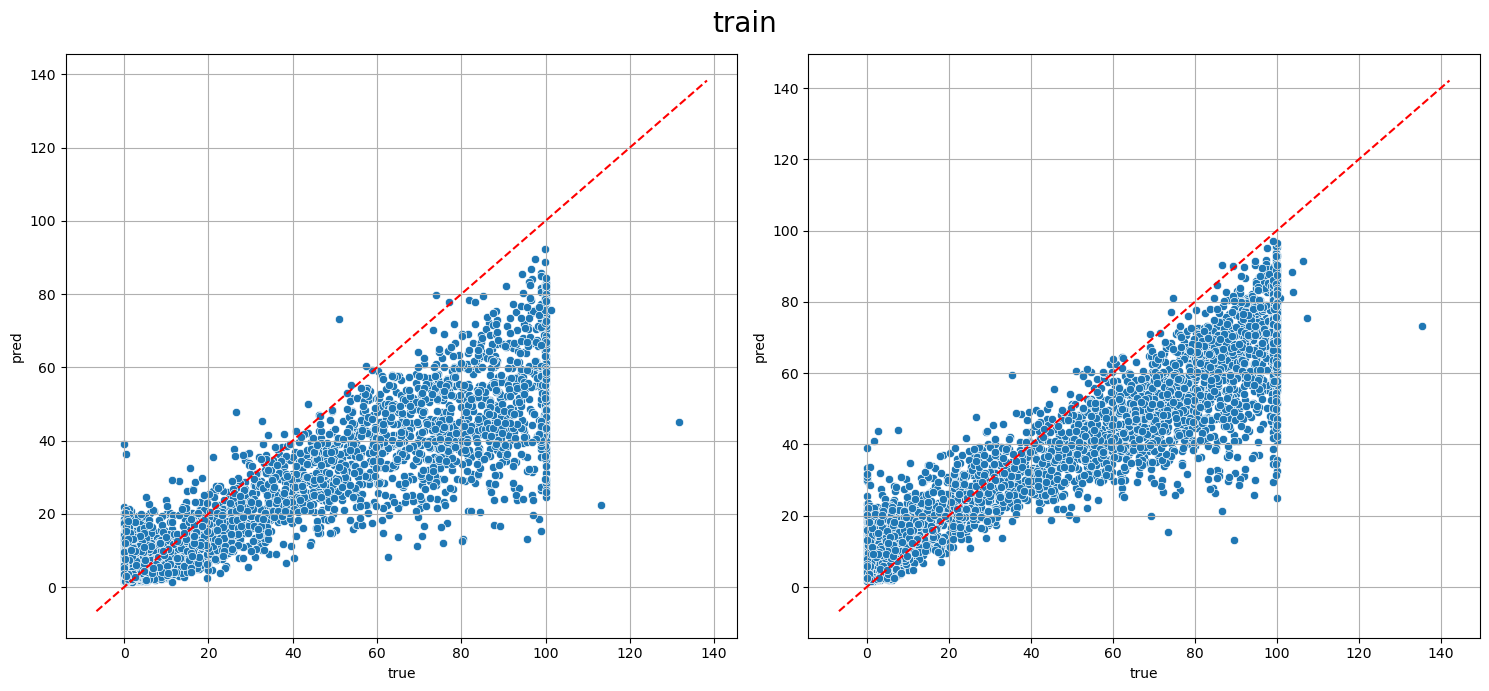

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
plt.suptitle('train',fontsize=20)
plt.tight_layout()
plt.show()

In [62]:
test_dataset = CustomDataset(test_df, ['MLM','HLM'], 'SMILES', 'FPs', fps_maximum, transform, True)
test_loader  = DataLoader(test_dataset , batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)

Setup smiles... : 100%|██████████| 483/483 [00:04<00:00, 118.97it/s]


In [63]:
te_pred = predict_test(best_model,test_loader,device,inverse_transform)

In [64]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[targets] = te_pred
submit.head()

,id,MLM,HLM
0,TEST_000,48.340534,92.337021
1,TEST_001,6.594205,14.886421
2,TEST_002,1.500639,4.196715
3,TEST_003,34.931969,3.471377
4,TEST_004,2.624461,87.813255


In [67]:
submit.to_csv('./out/mlt_efficientnet_mol&fps.csv',index=False)